**FIRST ATTEMP TO APPLY SSL TO THE SENTINEL-2 DATASET**

Reference tutorial: https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
# Reproducibility.
SEED = 42

***

***

# Split the dataset folder

In [4]:
import splitfolders

data_dir_initial = 'datasets/Sentinel2GlobalLULC_full_raw/Sentinel2LULC_JPEG/'

## Ratio (imbalanced)

## Ratio to create reduced sample

## Fixed (balanced)

***

***

# Imports

## Libraries and modules

In [5]:
import os

import torch
import torchvision

from torchinfo import summary

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead

import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Training checks.
import time

# Showing images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [6]:
# Hyperparamenters.
input_size = 224  # old_input_size = 256
batch_size = 32   # old_batch_size = 128
num_workers = 8
epochs = 1

# Dimension of the embeddings.
num_ftrs = 512

# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

## Reproducibility

In [7]:
# Seed torch and numpy.
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Enable CUDNN deterministic mode.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Issues a warning if it is not met.
torch.use_deterministic_algorithms(True)

In [8]:
# For dataloaders.
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [9]:
# Enable deterministic behavior using external GPU.
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

***

***

# Loading dataset

In [10]:
data_dir_target = 'datasets/Sentinel2GlobalLULC_full_ratio_seed=' + str(SEED)

## Custom tranforms (w/o normalization)

Define the augmentations for self-supervised learning.

In [11]:
# Data augmentations for the train dataset.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size,
                                             scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
])

## ImageFolder

In [12]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/')

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/')

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/')

# Building the lightly datasets from the PyTorch datasets.
train_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(train_data)

test_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(
    test_data,
    transform=test_transform
)

## Collate functions

PyTorch uses a Collate Function to combine the data in your batches together.

BaseCollateFunction (base class) takes a batch of images as input and transforms each image into two different augmentations with the help of random transforms. The images are then concatenated such that the output batch is exactly twice the length of the input batch.

In [13]:
# Base class for other collate implementations.
# This allows training.
collate_fn_train = lightly.data.collate.BaseCollateFunction(train_transform)

## PyTorch dataloaders

In [14]:
# Dataloader for training.
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data_lightly,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_train,
    drop_last=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for embedding.
dataloader_test = torch.utils.data.DataLoader(
    test_data_lightly,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

## Check the balance and size of the dataset

In [15]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [16]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([2800,  932, 1775, 2800, 2389,  889,  271, 2800, 2089, 1276,  577,
        115,  253, 2800,  784,  775, 2799,   84,   99,  842, 2800, 2800,
       2800,  402,  169,  204,   71,   83, 2518]))


In [17]:
# Check the size of each dataset.
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

136403
19478
38996


## See some samples (lightly dataset)

torch.Size([32, 3, 224, 224])
torch.Size([32])


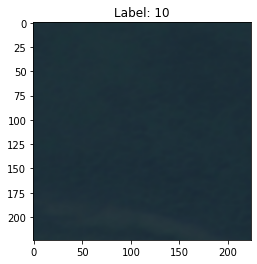

In [18]:
# Accessing Data and Targets in a PyTorch DataLoader.
for images, labels, names in dataloader_train_simsiam:
    img = images[0][0]
    label = labels[0]
    print(images[0].shape)
    print(labels.shape)
    plt.title("Label: " + str(int(label)))
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.show()
    break  # Only one batch.

# SimSiam model

In [20]:
Image(url="https://user-images.githubusercontent.com/"
      "2420753/118343499-4c410100-b4de-11eb-9313-d49e65440a7e.png",
      width=700,
      height=700)

Given an image, we create two augmented views and process these two versions with the same encoder network (a backbone plus a projection MLP).

The predictor is another MLP and on the other side a stop-gradient operation is applied. And we maximize the similarity at the end.

## Creation

In [21]:
# Copied from the reference tutorial.
class SimSiam(torch.nn.Module):

    # Constructor.
    def __init__(self, backbone, num_ftrs, proj_hidden_dim,
                 pred_hidden_dim, out_dim):

        # Inheritance.
        super().__init__()

        # Blackbone model.
        self.backbone = backbone

        # Projection head (lightly).
        self.projection_head = SimSiamProjectionHead(
            num_ftrs, proj_hidden_dim, out_dim)

        # Prediction head (lightly).
        self.prediction_head = SimSiamPredictionHead(
            out_dim, pred_hidden_dim, out_dim)

    # In the forward function, you define how your model
    # is going to be run, from input to output.
    def forward(self, x):

        # Get representations.
        f = self.backbone(x).flatten(start_dim=1)

        # Get projections.
        z = self.projection_head(f)

        # Get predictions.
        p = self.prediction_head(z)

        # Stop gradient.
        z = z.detach()

        return z, p

## Backbone net (w/ ResNet18)

This is different from the tutorial: resnet without pretrained weights.

In [22]:
# Resnet trained from scratch.
resnet = torchvision.models.resnet18(weights=None)

# Removing head from resnet. Embedding.
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])

# Model creation.
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

In [23]:
# Model structure.
summary(backbone, input_size=(batch_size, 3, input_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 512, 1, 1]           --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

## Training setup

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.



In [24]:
# SimSiam uses a symmetric negative cosine similarity loss.
criterion = lightly.loss.NegativeCosineSimilarity()

# Scale the learning rate.
lr = 0.05 * batch_size / 256

# Use SGD with momentum and weight decay.
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

## Training

### Loop

In [25]:
# Training on GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model.to(device)

# Setup.
avg_loss = 0.
avg_output_std = 0.

# Main training loop.
for e in range(epochs):

    # Timer added.
    t0 = time.time()

    # Iterating through the dataloader (lightly dataset is different).
    for (x0, x1), _, _ in dataloader_train_simsiam:

        # Move images to the GPU.
        x0 = x0.to(device)
        x1 = x1.to(device)

        # Run the model on both transforms of the images:
        # We get projections (z0 and z1) and
        # predictions (p0 and p1) as output.
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # Apply the symmetric negative cosine similarity
        # and run backpropagation.
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Calculate the per-dimension standard deviation of the outputs.
        # We can use this later to check whether the embeddings are collapsing.
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # Use moving averages to track the loss and standard deviation.
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

    # The level of collapse is large if the standard deviation of the L2
    # normalized output is much smaller than 1 / sqrt(dim).
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)

    # Print intermediate results (timing added).
    print(f'[Epoch {e:3d}] '
          f'Loss = {avg_loss:.2f} | '
          f'Collapse Level: {collapse_level:.2f} / 1.00 | '
          f'Duration: {(time.time()-t0):.2f} s')

Using cuda device
[Epoch   0] Loss = -0.98 | Collapse Level: 0.07 / 1.00 | Duration: 620.44 s


### Saving the pretrained backbone model

We will load this model in another notebook.

In [26]:
# Save this pretrained model (recommended approach).
torch.save(backbone.state_dict(), 'pytorch_models/simsiam_backbone_resnet18')

### Checking the weights

In [27]:
# First convolutional layer weights.
print(model.backbone[0])
print(model.backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [29]:
# Check the weights of one layer.
# model.layer[0].weight

## Embeddings for the samples of the test dataset

In [30]:
# Empty lists.
embeddings = []
filenames = []

# Disable gradients for faster calculations.
# Put the model in evaluation mode.
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):

        # Move the images to the GPU.
        x = x.to(device)

        # Embed the images with the pre-trained backbone.
        y = model.backbone(x).flatten(start_dim=1)

        # Store the embeddings and filenames in lists.
        embeddings.append(y)
        filenames = filenames + list(fnames)

# Concatenate the embeddings and convert to numpy.
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

# Scatter Plot and Nearest Neighbors

## Imports

In [31]:
# For plotting.
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# For resizing images to thumbnails.
import torchvision.transforms.functional as functional

# For clustering and 2d representations-
from sklearn import random_projection

## Plot some examples

### Definitions

In [32]:
# Test data.
data_dir_test = data_dir_target + '/test/'
print(data_dir_test)

datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/


In [33]:
# For the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection.
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# Normalize the embeddings to fit in the [0, 1] square.
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [34]:
def get_scatter_plot_with_thumbnails():
    """
    Creates a scatter plot with image overlays.

    """

    # Initialize empty figure and add subplot.
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)

    # Shuffle images and find out which images to show.
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:

        # Only show image if it is sufficiently far away from the others.
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # Plot image overlays.
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 10.)
        path = os.path.join(data_dir_test, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # Set aspect ratio.
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')

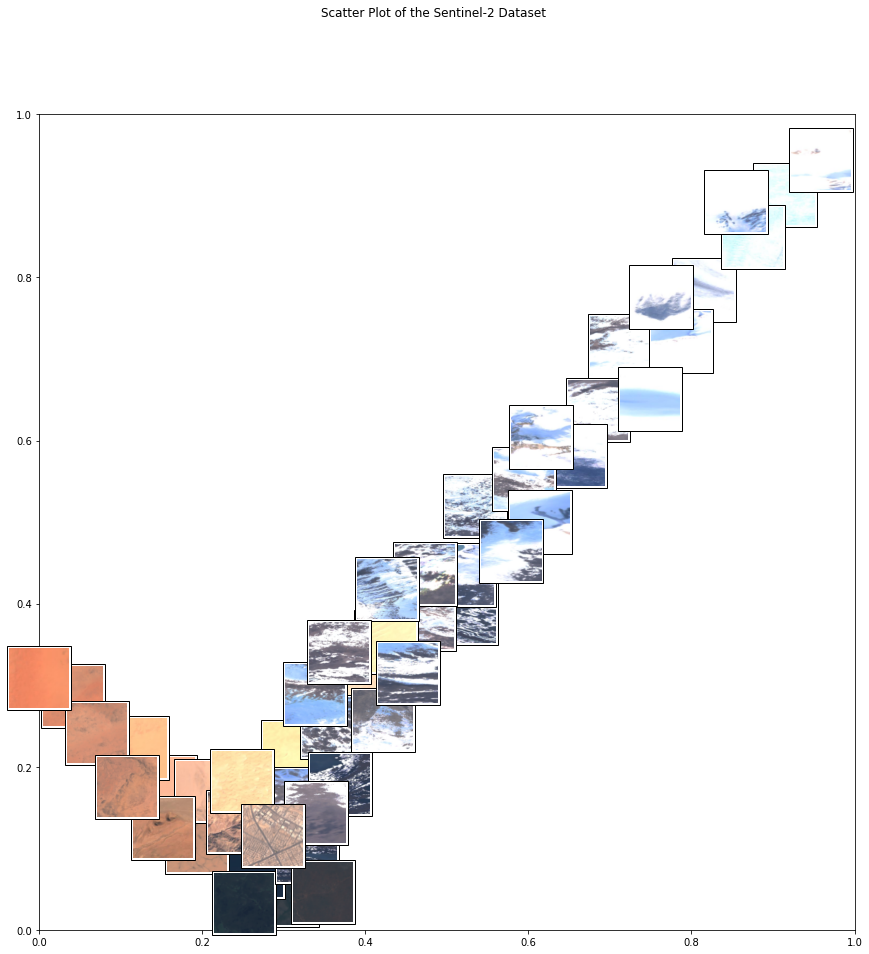

In [35]:
# Get a scatter plot with thumbnail overlays.
get_scatter_plot_with_thumbnails()

### Pick up one random sample per class

In [36]:
# List of subdirectories (classes).
directory_list = []
for root, dirs, files in os.walk(data_dir_test):
    for dirname in sorted(dirs):
        directory_list.append(os.path.join(root, dirname))
        print(dirname)

01_BarrenLands___jpeg
02_MossAndLichen_jpeg
03_Grasslands____jpeg
04_ShrublandOpen_jpeg
05_SrublandClose_jpeg
06_ForestsOpDeBr_jpeg
07_ForestsClDeBr_jpeg
08_ForestsDeDeBr_jpeg
09_ForestsOpDeNe_jpeg
10_ForestsClDeNe_jpeg
11_ForestsDeDeNe_jpeg
12_ForestsOpEvBr_jpeg
13_ForestsClEvBr_jpeg
14_ForestsDeEvBr_jpeg
15_ForestsOpEvNe_jpeg
16_ForestsClEvNe_jpeg
17_ForestsDeEvNe_jpeg
18_WetlandMangro_jpeg
19_WetlandSwamps_jpeg
20_WetlandMarshl_jpeg
21_WaterBodyMari_jpeg
22_WaterBodyCont_jpeg
23_PermanentSnow_jpeg
24_CropSeasWater_jpeg
25_CropCereaIrri_jpeg
26_CropCereaRain_jpeg
27_CropBroadIrri_jpeg
28_CropBroadRain_jpeg
29_UrbanBlUpArea_jpeg


In [37]:
# List of files (samples).
example_images = []
for classes in directory_list:
    random_file = np.random.choice(os.listdir(classes))
    path_to_random_file = classes + '/' + random_file
    example_images.append(path_to_random_file[53:])
    print(path_to_random_file)

datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/01_BarrenLands___jpeg/1_BarrenLands___100.0__2297000_0.3_(+23.2311518995,+6.9321193844)_DZ_Tamanghasset_nan_Tamanrasset.jpg
datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/02_MossAndLichen_jpeg/2_MossAndLichen_94.6__1335_0.0_(+68.9489319911,-69.9148005846)_CA_Nunavut_nan_Clyde-River.jpg
datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/03_Grasslands____jpeg/3_Grasslands____100.0__6683_21.6_(+16.5304385322,-14.0151557367)_SN_Saint-Louis_nan_Golere.jpg
datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/04_ShrublandOpen_jpeg/4_ShrublandOpen_99.1__14538_0.2_(-28.0806171293,+128.5913176389)_AU_South-Australia_Coober-Pedy_Coober-Pedy.jpg
datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/05_SrublandClose_jpeg/5_SrublandClose_80.7__09793_1.7_(-29.3080751335,+116.6789383192)_AU_Western-Australia_Yalgoo_Melville.jpg
datasets/Sentinel2GlobalLULC_full_ratio_seed=42/test/06_ForestsOpDeBr_jpeg/6_ForestsOpDeBr_81.9__2141_16.5_(+7.95835

In [38]:
def get_image_as_np_array(filename: str):
    """
    Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """
    Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape

    # Create an empty image with padding for the frame.
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)

    # Put the original image in the middle of the new one.
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_nxn(example_image: str, i: int):
    """
    Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 6

    # Initialize empty figure.
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")

    # Get indexes.
    example_idx = filenames.index(example_image)

    # Get distances to the cluster center.
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()

    # Sort indices by distance to the center.
    nearest_neighbors = np.argsort(distances)[:n_subplots]

    # Show images.
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)

        # Get the corresponding filename.
        fname = os.path.join(data_dir_test, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))

        # Let's disable the axis.
        plt.axis("off")

/tmp/ipykernel_30638/1966133675.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


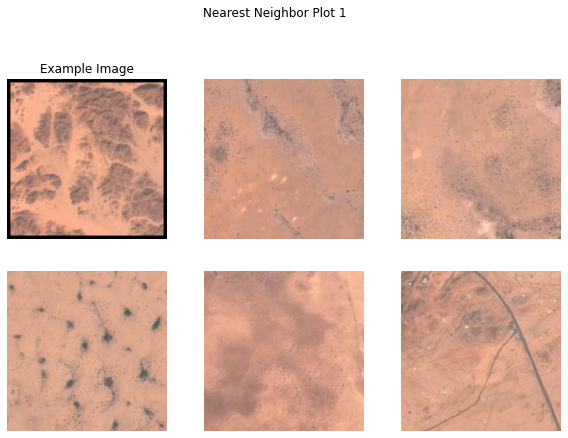

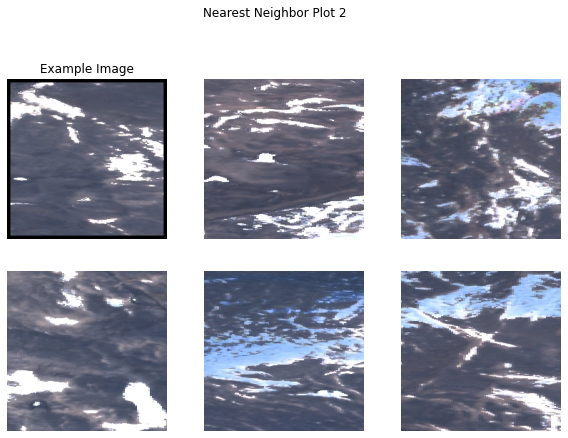

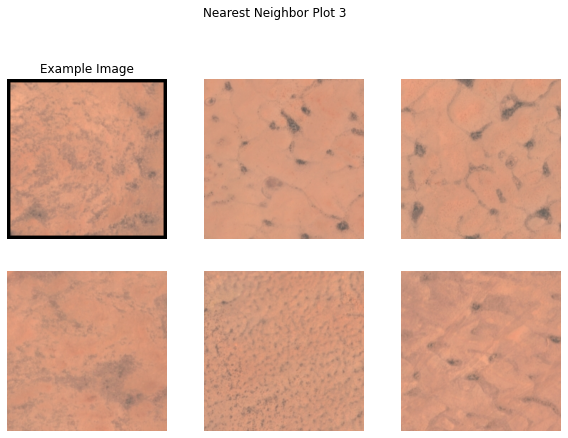

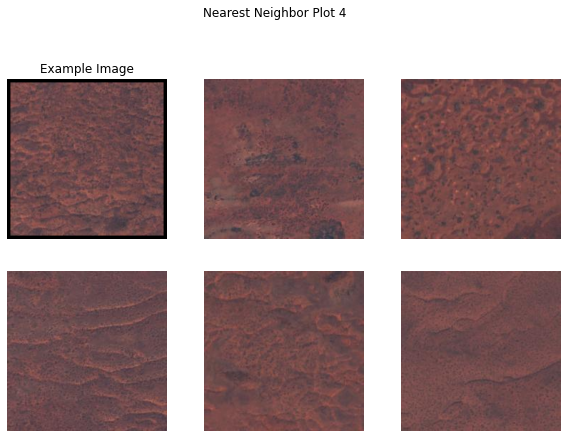

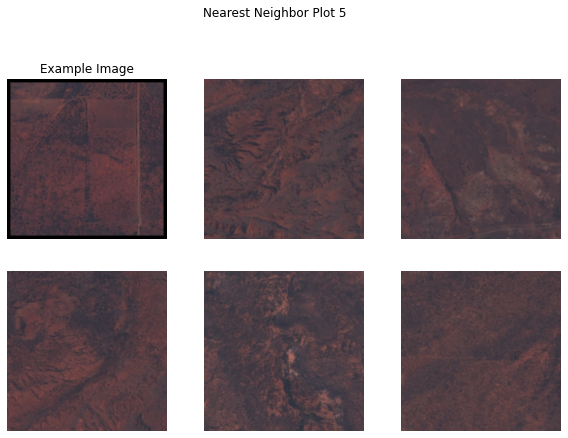

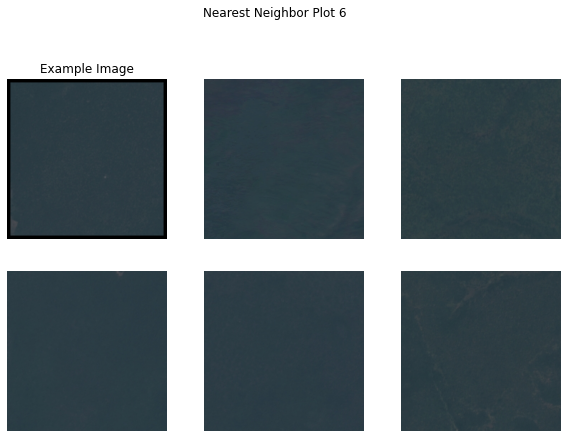

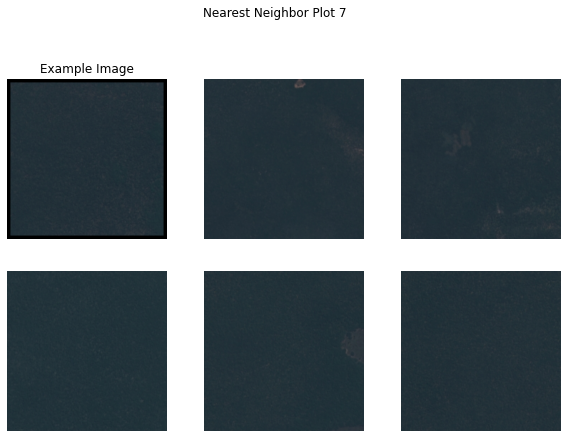

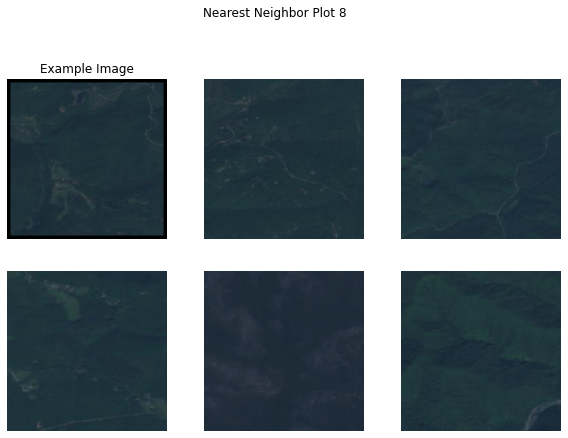

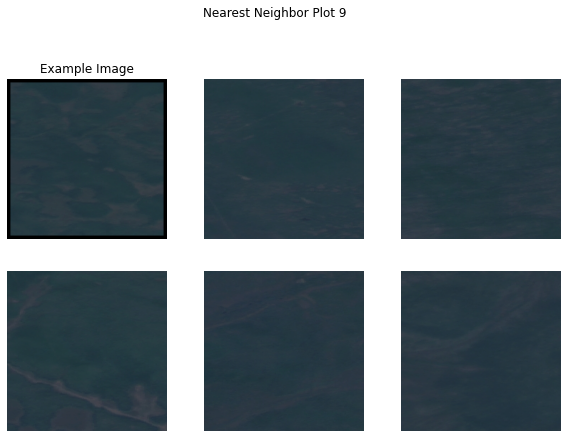

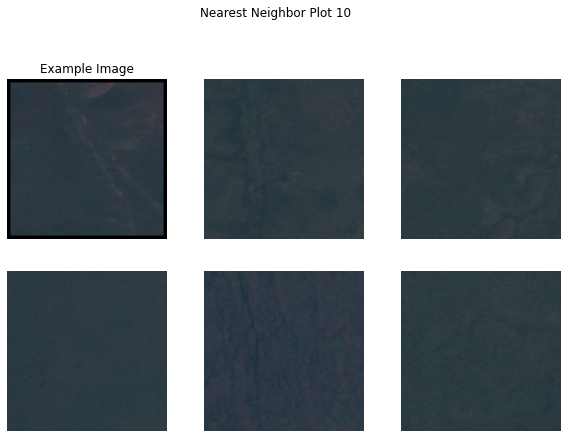

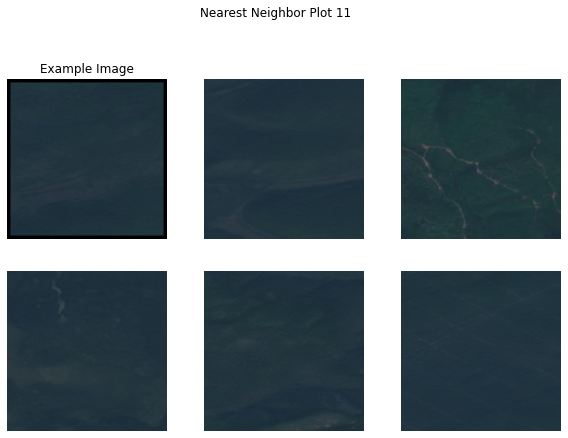

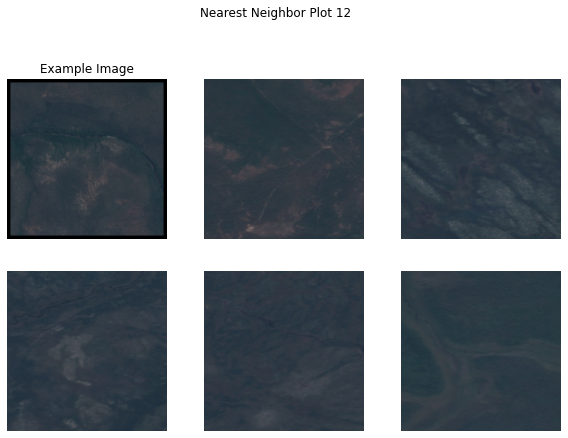

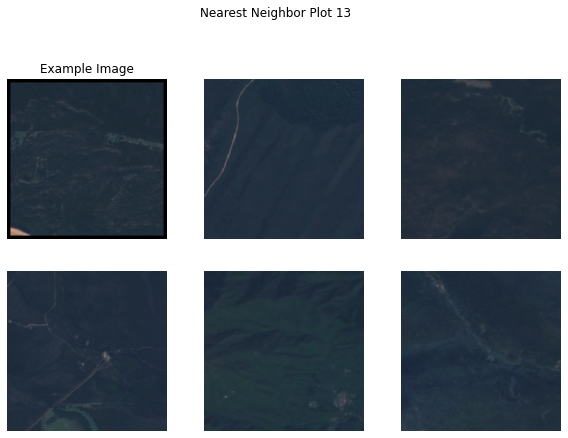

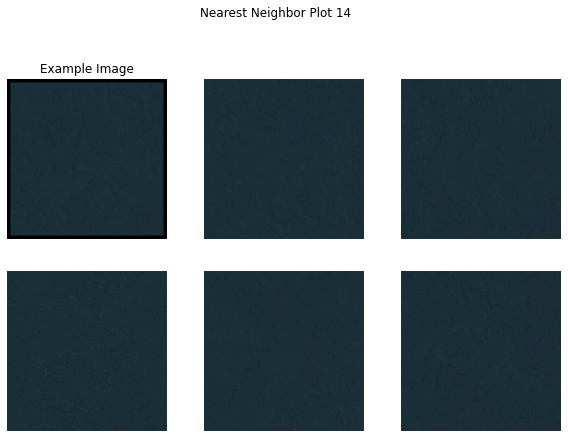

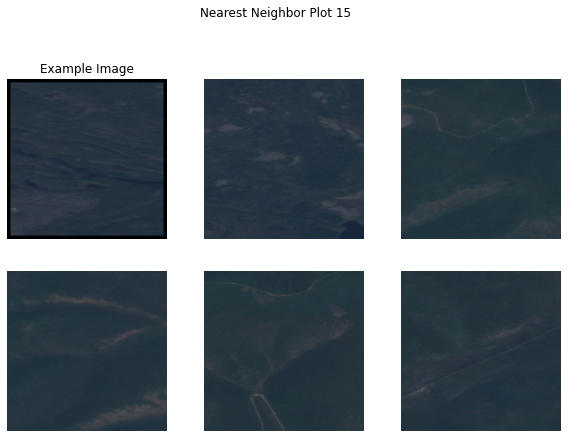

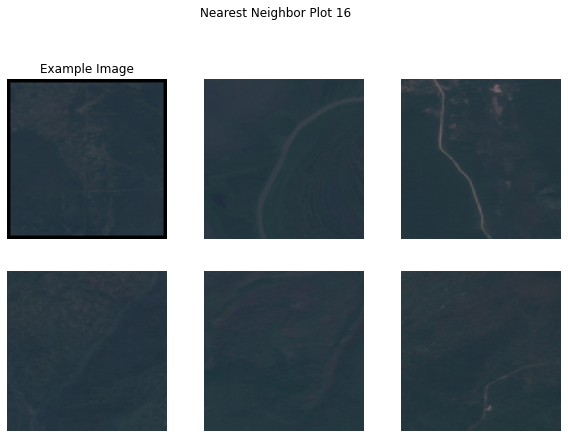

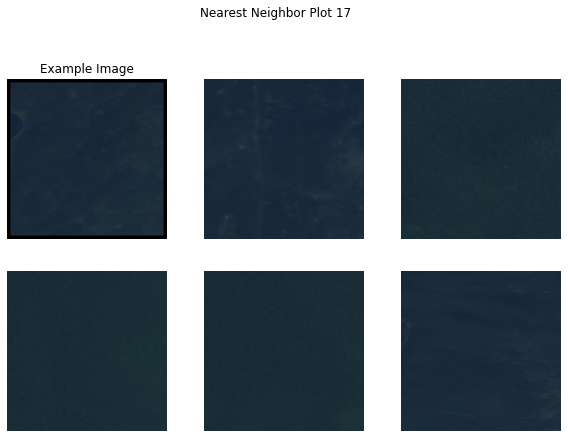

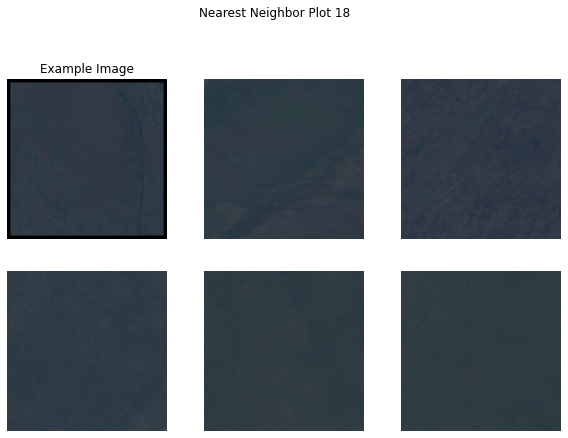

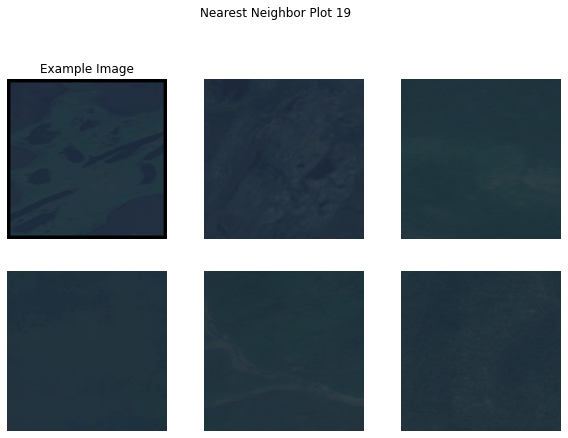

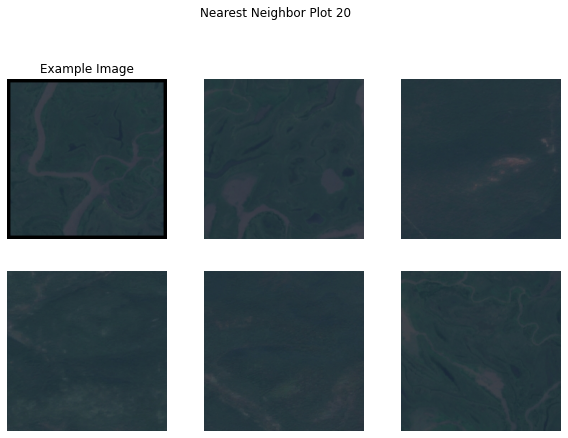

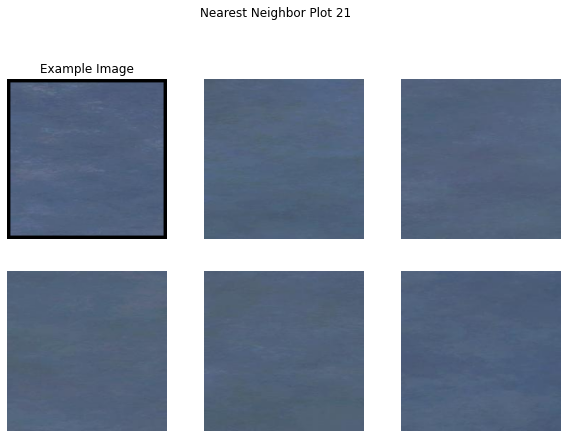

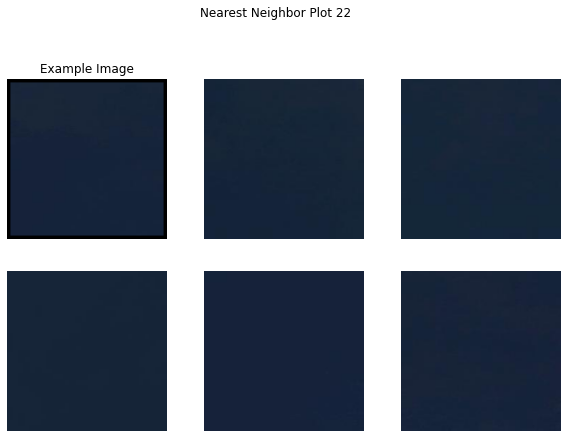

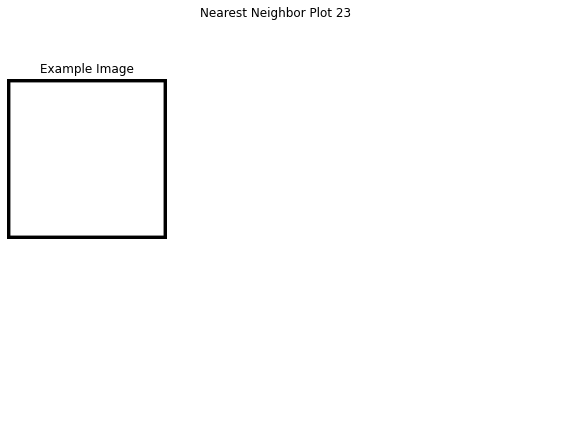

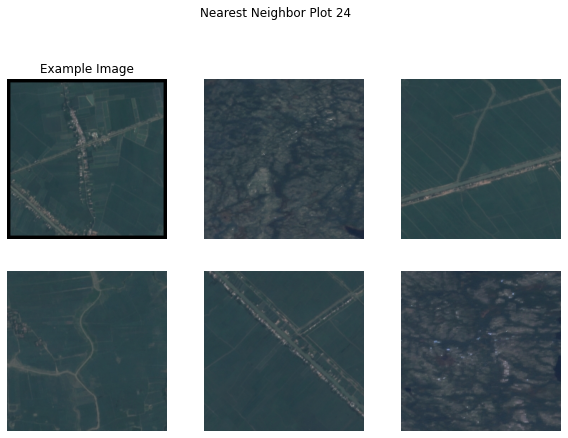

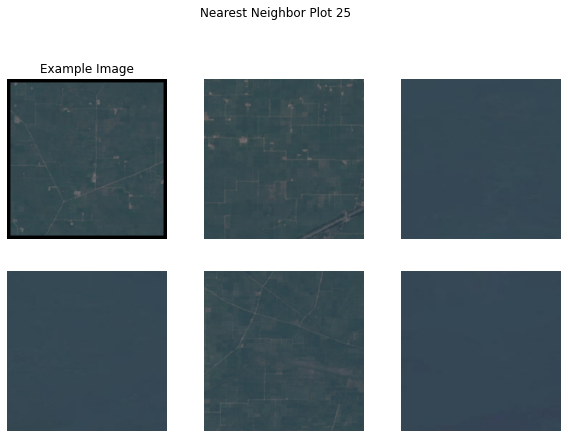

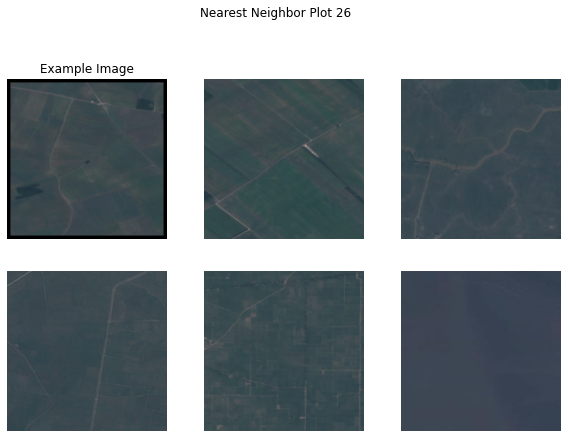

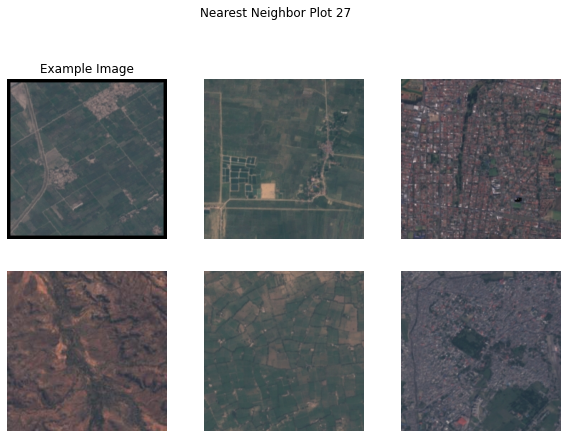

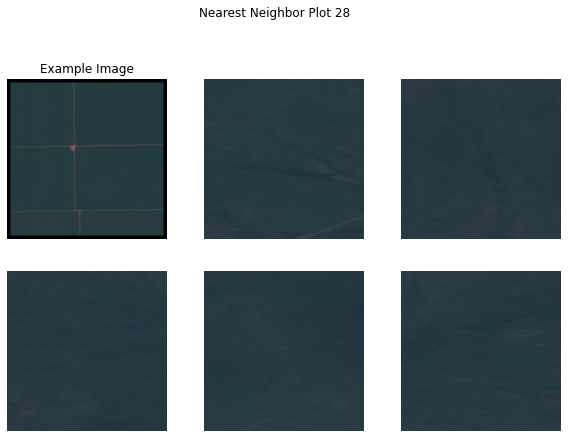

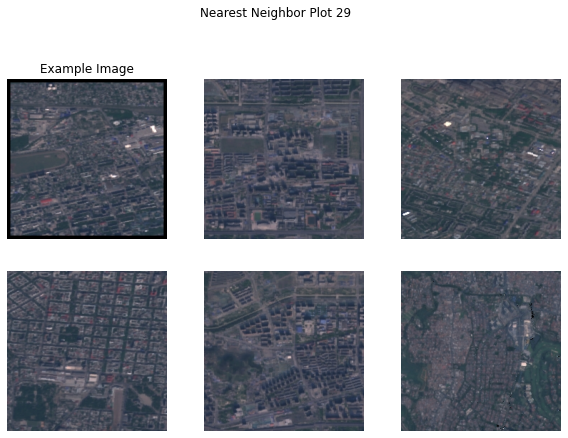

In [39]:
# Show example images for each cluster.
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_nxn(example_image, i)